# Importing Packages

In [67]:
using Distributions
using DataFrames
using QuadGK
using Roots
using StaticArrays
using Roots
using StaticArrays
using Random
using BenchmarkTools
using FastExpm
using Plots
using StatsBase
using Optim
using TensorCast
using Pipe

# Testing Code

A type storing the status at the end of a call to `ssa`:

- **termination_status** : whether the simulation stops at the final time (`finaltime`) or early due to zero propensity function (`zeroprop`)
- **nsteps** : the number of steps taken during the simulation.

In [68]:
struct SSAStats
    termination_status::String
    nsteps::Int64
end

A type storing the call to `ssa`:

- **x<sub>0</sub>** : a `Vector` of `Int64`, representing the initial states of the system.
- **F** : a `Function` or a callable type, which itself takes two arguments; x, a `Vector` of `Int64` representing the states, and parms, a `Vector` of `Float64` representing the parameters of the system.
- **$\nu$** : a `Matrix` of `Int64`, representing the transitions of the system, organised by row.
- **parms** : a `Vector` of `Float64` representing the parameters of the system.
- **tf** : the final simulation time (`Float64`).
- **alg** : the algorithm used (`Symbol`, either `:gillespie`, `jensen`, or `tjc`).
- **tvc** : whether rates are time varying.

In [7]:
struct SSAArgs{X,Ftype,N,P}
    x0::X
    F::Ftype
    nu::N
    parms::P
    tf::Float64
    alg::Symbol
    tvc::Bool
end

This type stores the output of `ssa`, and comprises of:

- **time** : a `Vector` of `Float64`, containing the times of simulated events.
- **data** : a `Matrix` of `Int64`, containing the simulated states.
- **stats** : an instance of `SSAStats`.
- **args** : arguments passed to `ssa`.

In [10]:
struct SSAResult
    time::Vector{Float64}
    data::Matrix{Int64}
    stats::SSAStats
    args::SSAArgs
end

This function is a substitute for `StatsBase.sample(wv::WeightVec)`, which avoids recomputing the sum and size of the weight vector, as well as a type conversion of the propensity vector. It takes the following arguments:

- **w** : an `Array{Float64,1}`, representing propensity function weights.
- **s** : the sum of `w`.
- **n** : the length of `w`.

In [8]:
function pfsample(w::AbstractArray{Float64,1},s::Float64,n::Int64)
    t = rand() * s
    i = 1
    cw = w[1]
    while cw < t && i < n
        i += 1
        @inbounds cw += w[i]
    end
    return i
end

pfsample (generic function with 1 method)

This function performs Gillespie's stochastic simulation algorithm. It takes the following arguments:

- **x<sub>0</sub>** : a `Vector` of `Int64`, representing the initial states of the system.
- **F** : a `Function` or a callable type, which itself takes two arguments; x, a `Vector` of `Int64` representing the states, and parms, a `Vector` of `Float64` representing the parameters of the system.
- **$\nu$** : a `Matrix` of `Int64`, representing the transitions of the system, organised by row.
- **parms** : a `Vector` of `Float64` representing the parameters of the system.
- **tf** : the final simulation time (`Float64`).

In [4]:
function gillespie(x0::AbstractVector{Int64},F::Base.Callable,nu::AbstractMatrix{Int64},
    parms::AbstractVector{Float64},tf::Float64)
    # Args
    args = SSAArgs(x0,F,nu,parms,tf,:gillespie,false)
    # Set up time array
    ta = Vector{Float64}()
    t = 0.0
    push!(ta,t)
    # Set up initial x
    nstates = length(x0)
    x = copy(x0')
    xa = copy(Array(x0))
    # Number of propensity functions
    numpf = size(nu,1)
    # Main loop
    termination_status = "finaltime"
    nsteps = 0
    while t <= tf
        pf = F(x,parms)
        # Update time
        sumpf = sum(pf)
        if sumpf == 0.0
            termination_status = "zeroprop"
            break
        end
        dt = rand(Exponential(1/sumpf))
        t += dt
        push!(ta,t)
        # Update event
        ev = pfsample(pf,sumpf,numpf)
        if x isa SVector
            @inbounds x[1] += nu[ev,:]
        else
            deltax = view(nu,ev,:)
            for i in 1:nstates
                @inbounds x[1,i] += deltax[i]
            end
        end
        for xx in x
            push!(xa,xx)
        end
        # update nsteps
        nsteps += 1
    end
    stats = SSAStats(termination_status,nsteps)
    xar = transpose(reshape(xa,length(x),nsteps+1))
    return SSAResult(ta,xar,stats,args)
end

gillespie (generic function with 1 method)

In [5]:
function ssa(x₀::AbstractVector{Int64},F::Base.Callable,nu::AbstractMatrix{Int64},parms::AbstractVector{Float64},
    times::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64})
    tf = times[end]
    
    gillespie_sim = gillespie(x₀,F,nu,parms,tf)
    ssa_result = Array{Int64,2}(undef,length(times),length(x₀))

    event_indx = 1
    for (time_indx,time) in enumerate(times)
        while gillespie_sim.time[event_indx]<time
            event_indx += 1
        end
        ssa_result[time_indx,:] = gillespie_sim.data[event_indx,:]
    end

    return ssa_result
end
        

ssa (generic function with 1 method)

In [9]:
times=0:0.1:1
tf = times[end]
    
gillespie_sim = gillespie(x₀,F,ν,reaction_rates,tf)
ssa_result = Array{Int64,2}(undef,length(times),length(x₀))

event_indx = 1
for time in times)
    if gillespie_sim.time[event_indx]<time
        event_indx += 1
    end
    ssa_result[time_indx,:] = gillespie_sim.data[event_indx,:]
    println(event_indx)
end

LoadError: UndefVarError: `x₀` not defined

# Gillespie

In [183]:
function F(x,parms)
    (DNA_Inactive,DNA_Active,mRNA,Protein) = x
    (kᴰᴺᴬ₁,kᴰᴺᴬ₂,kᵐ₁,kᵐ₂,kᴾ₁,kᴾ₂,r) = parms
    switch_Active = kᴰᴺᴬ₁*DNA_Inactive
    switch_Inactive = kᴰᴺᴬ₂*DNA_Active
    mRNA_birth = kᵐ₁*DNA_Active
    mRNA_death = kᵐ₂*mRNA
    protein_birth = kᴾ₁*mRNA
    protein_death = kᴾ₂*Protein
    repression =  r*Protein*DNA_Active
    return [switch_Active,switch_Inactive+repression,
    mRNA_birth,mRNA_death,
    protein_birth,protein_death]
 end

# function F(x,parms)
#   (DNA_Inactive,DNA_Active,mRNA) = x
#   (kᴰᴺᴬ₁,kᴰᴺᴬ₂,kᵐ₁,kᵐ₂) = parms
#   switch_Active = kᴰᴺᴬ₁*DNA_Inactive
#   switch_Inactive = kᴰᴺᴬ₂*DNA_Active
#   mRNA_birth = kᵐ₁*DNA_Active
#   mRNA_death = kᵐ₂*mRNA
#   return [switch_Active,switch_Inactive,mRNA_birth,mRNA_death]
# end

  x₀ = [0,1,0,0]
  ν = [[-1 1 0 0];[1 -1 0 0];[0 0 1 0];[0 0 -1 0];[0 0 0 1];[0 0 0 -1];[1 -1 0 0]]
  reaction_rates = [1.2,0.5,10.,.5,10.,0.5,.2]/2
  # x₀ = [0,1,0]
  # ν = [[-1 1 0];[1 -1 0];[0 0 1];[0 0 -1]]
  # reaction_rates = [1.2,0.5,40.,1.]
  tf = 10.
  Random.seed!(1234)
  
result = gillespie(x₀,F,ν,reaction_rates,tf)

SSAResult([0.0, 0.013748931419363944, 0.02110515303976869, 0.03790151358346594, 0.08219628995380451, 0.08867515836682863, 0.1413176599508671, 0.14149723050542393, 0.16205235236767357, 0.18826816671654026  …  9.902326616765514, 9.915896903069108, 9.932735388586025, 9.937747540294469, 9.965263474191627, 9.967364689575238, 9.972136277958478, 9.975708447817217, 9.99951570015129, 10.015213387387119], [0 1 0; 0 1 1; … ; 0 1 39; 0 1 40], SSAStats("finaltime", 632), SSAArgs{Vector{Int64}, typeof(F), Matrix{Int64}, Vector{Float64}}([0, 1, 0], F, [-1 1 0; 1 -1 0; 0 0 1; 0 0 -1], [1.2, 0.5, 40.0, 1.0], 10.0, :gillespie, false))

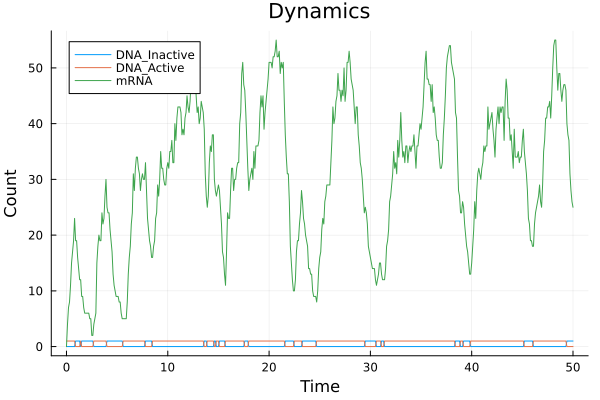

In [184]:
plot(0:.1:50,ssa(x₀,F,ν,reaction_rates,0:.1:50),labels=["DNA_Inactive" "DNA_Active" "mRNA" "Protein"])
xlabel!("Time")
ylabel!("Count")
title!("Dynamics")

In [185]:
times = 0:.01:50
n_simulations = 1000
species = Array{Int64,3}(undef,n_simulations,length(times),length(x₀))

for i in range(1,n_simulations)
    species[i,:,:] = ssa(x₀,F,ν,reaction_rates,times)
end

In [186]:
species_mean = @pipe species |> mean(_,dims=1) |> dropdims(_,dims=1)

5001×3 Matrix{Float64}:
 0.0    1.0     0.0
 0.019  0.981   1.362
 0.023  0.977   1.737
 0.013  0.987   2.101
 0.011  0.989   2.421
 0.011  0.989   2.774
 0.018  0.982   3.112
 0.017  0.983   3.479
 0.018  0.982   3.795
 0.021  0.979   4.153
 0.026  0.974   4.489
 0.027  0.973   4.851
 0.03   0.97    5.187
 ⋮             
 0.286  0.714  28.112
 0.287  0.713  28.064
 0.28   0.72   28.089
 0.276  0.724  28.049
 0.273  0.727  28.015
 0.273  0.727  28.009
 0.272  0.728  28.013
 0.275  0.725  27.995
 0.274  0.726  27.97
 0.272  0.728  27.987
 0.271  0.729  28.024
 0.271  0.729  28.068

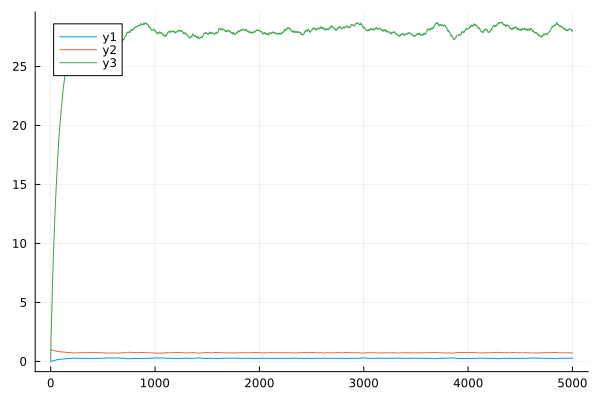

In [187]:
plot(species_mean)

# Finite State Projection

Finding number of unique states available for the FSP algorithm

In [188]:
@cast data[(i,j),k] := species[i,j,k];

In [189]:
state_space = unique(data,dims=1);

In [190]:
size(state_space)[1]

134

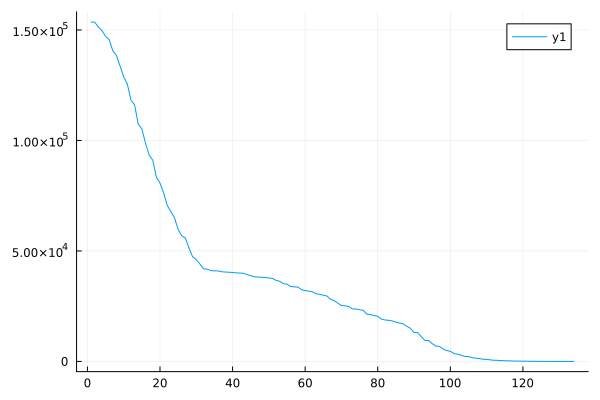

In [192]:
plot(countmap(eachrow(data))|>values|>collect|>sort|>reverse)

In [195]:
mRNA_max = state_space[:,3] |> maximum

69

In [196]:
init_prob = zeros(Int64,size(state_space,1))
init_prob[1] = 1
typeof(init_prob)

Vector{Int64} (alias for Array{Int64, 1})

Finds the index of the change in state in the stoichiometric matrix

- **state_change** : a `Vector` of `Int64` indicating the change in states in a event
- **updates** : a `AbstractMatrix` of `Int64` representing the stoichiomaetric matrix.

In [133]:
function index_reaction(state_change::AbstractVector{Int64},updates::AbstractMatrix{Int64})
    for (indx,update) in enumerate(eachrow(updates))
        if update==state_change
            return indx
        end
    end 
    return -1
end

index_reaction (generic function with 1 method)

Finds the distribution of the states at a time point point

- **t** : Time point `t` (`Float64`)
- **reaction_rates** : a `Vector` of `Float64` defining the reaction rates
- **states** : a `AbstractMatrix` of `Int64` representing the space of all available states
- **init_prob** : a `Vector` of `Float64` defining the initial distribution of the states
- **updates** : a `AbstractMatrix` of `Int64` representing the stoichiomaetric matrix.

In [206]:
#Transition Matrix
function transition_matrix(reaction_rates::AbstractArray{Float64,1},
    states::AbstractArray{Int64,2},updates::AbstractArray{Int64,2})

    n = size(states,1)

    Q_Matrix = Matrix{Float64}(undef,n,n)

    for i in range(1,n)
        for j in range(1,n)
            v = states[j,:]-states[i,:]

            index = index_reaction(v,updates)
            if index>=0
                propensity = F(states[i,:],reaction_rates)
                Q_Matrix[j,i] = propensity[index]
            else
                Q_Matrix[j,i] = 0
            end
        end
    end

    for i in range(1,n)
        Q_Matrix[i,i] = -sum(Q_Matrix[:,i])
    end

    return Q_Matrix
end


transition_matrix (generic function with 2 methods)

In [208]:
#State Distribution
function state_distribution(t::Float64,reaction_rates::AbstractArray{Float64,1},
    states::AbstractArray{Int64,2},updates::AbstractArray{Int64,2},init_prob::AbstractArray{Int64,1})
    
    n = size(states,1)
    Q_Matrix = transition_matrix(reaction_rates,states,updates)

    exp_Q = exp(Q_Matrix*t)
    state_distribution = exp_Q*init_prob

    return state_distribution
end

state_distribution (generic function with 1 method)

In [217]:
#Displacement Matrix
function displacement(reaction_rates::AbstractArray{Float64,1},
    states::AbstractArray{Int64,2},updates::AbstractArray{Int64,2})
    
    n = size(states,1)
    E = Array{Int64,3}(undef,4,n,n);
    fill!(E, 0);

    for i in range(1,n)
        for j in range(1,n)
            v = states[j,:]-states[i,:]

            index = index_reaction(v,updates)
            if index>=0
                E[index,j,i] = 1
            end
        end
    end

    for i in range(1,n)
        for index in range(1,4)
            E[index,i,i] = -1
        end
    end

    return E
end

displacement (generic function with 2 methods)

In [63]:
#Count Distribution
function count_distribution(t::Float64,reaction_rate::AbstractArray{Float64,1},
    states::AbstractArray{Int64,2},updates::AbstractArray{Int64,2},init_prob::AbstractArray{Int64,1})

    count_distribution = Vector{Vector{Float64}}(undef, size(states,2))
    state_distribution_array = state_distribution(t,reaction_rate,states,updates,init_prob)

    for (state_indx,state) in enumerate(eachcol(states))
        count_distribution[state_indx] = zeros(length(unique!(sort!(vcat(state)))))
        for (indx,state_inst) in enumerate(eachrow(states))
            count_distribution[state_indx][state_inst[state_indx]+1] += state_distribution_array[indx]
        end
    end
    
    return count_distribution
end

count_distribution (generic function with 1 method)

In [201]:
#Likelihood
function likelihood(reaction_rates::AbstractArray{Float64,1},data::AbstractArray{Float64,2},
    states::AbstractArray{Int64,2},updates::AbstractArray{Int64,2},init_prob::AbstractArray{Int64,1})
    likelihood = 0
    for j in range(1,6)
        mRNA_count_dist = count_distribution(2.0*j,reaction_rates,states,updates,init_prob)[3][1:mRNA_max]
        if sum(mRNA_count_dist.<1e-10)>0
            continue
        end
        likelihood += data[j,:]'*log.(mRNA_count_dist)
    end
    @info "Current point: $reaction_rates"
    return exp(likelihood-likeli_const)
end

likelihood (generic function with 1 method)

In [114]:
data_hist = zeros(6,mRNA_max)

6×22 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [219]:
E = displacement(reaction_rates,state_space,ν);

In [230]:
reaction_rates

4-element Vector{Float64}:
  1.2
  0.5
 40.0
  1.0

In [233]:
Q = transition_matrix(reaction_rates,state_space,ν);
h = 1e-10
ha = [0,0,h,0]
Q_h = transition_matrix(reaction_rates+ha,state_space,ν);
(exp(Q_h).-exp(Q))./h

134×134 Matrix{Float64}:
 -1.6481e-5    -1.04203e-5   -6.58599e-6   …  -9.03307e-19  -7.30643e-17
 -3.41513e-5   -2.7658e-5    -2.13149e-5      -3.66298e-17  -2.7624e-15
 -5.30912e-5   -4.6135e-5    -3.9337e-5       -7.33688e-16  -5.14888e-14
 -7.33441e-5   -6.59152e-5   -5.8625e-5       -9.67787e-15  -6.30531e-13
 -0.000256913  -0.0001625    -0.000102678     -1.75374e-17  -5.22541e-17
 -9.5091e-5    -8.71135e-5   -7.93159e-5   …  -9.46108e-14  -5.71091e-12
 -0.000257259  -0.000257277  -0.000222357     -6.93346e-16  -1.96698e-15
 -0.00014426   -0.000134827  -0.000125676     -4.6516e-12   -2.39303e-10
 -0.000256531  -0.000257051  -0.000257155     -1.35194e-14  -3.66415e-14
 -0.000118529  -0.000109938  -0.000101525     -7.31069e-13  -4.07924e-11
 -0.0002549    -0.000255698  -0.000256149  …  -1.73377e-13  -4.45644e-13
 -0.00017362   -0.000162873  -0.000152552     -2.50729e-11  -1.18624e-9
 -0.000252385  -0.000253391  -0.000254293     -1.64493e-12  -4.01183e-12
  ⋮                         

In [146]:
likeli_const = likelihood(reaction_rates,data_hist,state_space,ν,init_prob)

LoadError: InterruptException:

In [117]:
for (indx,specie) in enumerate(eachcol(species[:,200:200:1200,3]))
    count = specie |> countmap 
    prob = @pipe count  |> sort(_,by=x->x[1]) |> values |> collect |> _/sum(_)
    data_hist[indx,1:length(prob)] = prob
end

In [332]:
lower = [0.1,0.1]
upper = [2.,2.]
result = optimize((x->-likeli_inst(x[1],x[2])), 
                            lower,upper,[1.,1.], 
                            Fminbox(BFGS()),
                            Optim.Options(show_trace=true))

[ Info: Current point: 1.0000060554544523,1.0
[ Info: Current point: 0.9999939445455476,1.0
[ Info: Current point: 1.0,1.0000060554544523
[ Info: Current point: 1.0,0.9999939445455476


Fminbox
-------
Initial mu = 0.000189581

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.000189581

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     1.944431e-01     4.657062e-01
 * time: 7.796287536621094e-5


[ Info: Current point: 1.0,1.0
[ Info: Current point: 0.5342998327816385,1.334747396643957
[ Info: Current point: 0.5342877218727337,1.334747396643957
[ Info: Current point: 0.5342937773271861,1.3347554791460228
[ Info: Current point: 0.5342937773271861,1.334739314141891
[ Info: Current point: 0.5342937773271861,1.334747396643957
[ Info: Current point: 0.7651218978144639,1.1688336046523795
[ Info: Current point: 0.7651097869055591,1.1688336046523795
[ Info: Current point: 0.7651158423600115,1.168840682471035
[ Info: Current point: 0.7651158423600115,1.1688265268337241
[ Info: Current point: 0.7651158423600115,1.1688336046523795


     1     9.099000e-02     1.737602e-01
 * time: 32.42602300643921


[ Info: Current point: 0.570109050689854,1.1104088925959354
[ Info: Current point: 0.5700969397809491,1.1104088925959354
[ Info: Current point: 0.5701029952354015,1.110415616626408
[ Info: Current point: 0.5701029952354015,1.1104021685654628
[ Info: Current point: 0.5701029952354015,1.1104088925959354
[ Info: Current point: 0.6016959871527944,1.1198721546056083
[ Info: Current point: 0.6016838762438895,1.1198721546056083
[ Info: Current point: 0.601689931698342,1.119878935940433
[ Info: Current point: 0.601689931698342,1.1198653732707835
[ Info: Current point: 0.601689931698342,1.1198721546056083


     2     7.253764e-02     1.690057e-01
 * time: 67.97400617599487


[ Info: Current point: 0.4917314515257758,0.9761365765220081
[ Info: Current point: 0.49171934061687106,0.9761365765220081
[ Info: Current point: 0.49172539607132343,0.9761426319764606
[ Info: Current point: 0.49172539607132343,0.9761305210675557
[ Info: Current point: 0.49172539607132343,0.9761365765220081
[ Info: Current point: 0.2718023802717387,0.6886654203548079
[ Info: Current point: 0.27179026936283396,0.6886654203548079
[ Info: Current point: 0.27179632481728633,0.6886714758092604
[ Info: Current point: 0.27179632481728633,0.6886593649003555
[ Info: Current point: 0.27179632481728633,0.6886654203548079
[ Info: Current point: 0.34367044561359317,0.7826047787012027
[ Info: Current point: 0.34365833470468843,0.7826047787012027
[ Info: Current point: 0.3436643901591408,0.7826108341556551
[ Info: Current point: 0.3436643901591408,0.7825987232467503


     3     3.784384e-02     4.099265e-01
 * time: 120.960529088974


[ Info: Current point: 0.3436643901591408,0.7826047787012027
[ Info: Current point: 0.29791622066515827,0.6849947465287195
[ Info: Current point: 0.29790410975625353,0.6849947465287195
[ Info: Current point: 0.2979101652107059,0.6850008019831719
[ Info: Current point: 0.2979101652107059,0.6849886910742671
[ Info: Current point: 0.2979101652107059,0.6849947465287195
[ Info: Current point: 0.11489932087141869,0.2945546178387868
[ Info: Current point: 0.11488720996251389,0.2945546178387868
[ Info: Current point: 0.11489326541696629,0.29456067329323915
[ Info: Current point: 0.11489326541696629,0.2945485623843344
[ Info: Current point: 0.11489326541696629,0.2945546178387868
[ Info: Current point: 0.2754321699379293,0.6370282709228938
[ Info: Current point: 0.27542005902902456,0.6370282709228938
[ Info: Current point: 0.2754261144834769,0.6370343263773462
[ Info: Current point: 0.2754261144834769,0.6370222154684414


     4     1.838035e-02     4.175846e-01
 * time: 170.8786699771881


[ Info: Current point: 0.2754261144834769,0.6370282709228938
[ Info: Current point: 0.25799420495679265,0.57596114849684
[ Info: Current point: 0.2579820940478879,0.57596114849684
[ Info: Current point: 0.2579881495023403,0.5759672039512924
[ Info: Current point: 0.2579881495023403,0.5759550930423876
[ Info: Current point: 0.2579881495023403,0.57596114849684
[ Info: Current point: 0.18824234503224616,0.3316926587926247
[ Info: Current point: 0.18823023412334136,0.3316926587926247
[ Info: Current point: 0.18823628957779376,0.3316987142470771
[ Info: Current point: 0.18823628957779376,0.33168660333817235
[ Info: Current point: 0.18823628957779376,0.3316926587926247
[ Info: Current point: 0.24733863118580313,0.538645714689239
[ Info: Current point: 0.24732652027689833,0.538645714689239
[ Info: Current point: 0.24733257573135073,0.5386517701436915
[ Info: Current point: 0.24733257573135073,0.5386396592347866


     5     3.732244e-03     2.315654e-01
 * time: 223.41065311431885


[ Info: Current point: 0.24733257573135073,0.538645714689239
[ Info: Current point: 0.2614132896351419,0.4977828583033142
[ Info: Current point: 0.26140117872623714,0.4977828583033142
[ Info: Current point: 0.2614072341806895,0.49778891375776657
[ Info: Current point: 0.2614072341806895,0.49777680284886183
[ Info: Current point: 0.2614072341806895,0.4977828583033142
[ Info: Current point: 0.2575008740574856,0.5091417467940919
[ Info: Current point: 0.2574887631485809,0.5091417467940919
[ Info: Current point: 0.25749481860303325,0.5091478022485443
[ Info: Current point: 0.25749481860303325,0.5091356913396394
[ Info: Current point: 0.25749481860303325,0.5091417467940919


     6     1.024361e-04     2.233646e-02
 * time: 260.33391213417053


[ Info: Current point: 0.28472906545817905,0.5438781780193034
[ Info: Current point: 0.2847169545492743,0.5438781780193034
[ Info: Current point: 0.2847230100037267,0.5438842334737558
[ Info: Current point: 0.2847230100037267,0.543872122564851
[ Info: Current point: 0.2847230100037267,0.5438781780193034
[ Info: Current point: 0.27102253397592013,0.5263920372337072
[ Info: Current point: 0.2710104230670154,0.5263920372337072
[ Info: Current point: 0.27101647852146776,0.5263980926881596
[ Info: Current point: 0.27101647852146776,0.5263859817792548
[ Info: Current point: 0.27101647852146776,0.5263920372337072


     7    -6.147641e-05     7.119736e-03
 * time: 299.3375780582428


[ Info: Current point: 0.2710214650649725,0.5247845675051792
[ Info: Current point: 0.27100935415606775,0.5247845675051792
[ Info: Current point: 0.2710154096105201,0.5247906229596316
[ Info: Current point: 0.2710154096105201,0.5247785120507268
[ Info: Current point: 0.2710154096105201,0.5247845675051792
[ Info: Current point: 0.2710171894211818,0.518354688591067
[ Info: Current point: 0.27100507851227706,0.518354688591067
[ Info: Current point: 0.27101113396672943,0.5183607440455195
[ Info: Current point: 0.27101113396672943,0.5183486331366146
[ Info: Current point: 0.27101113396672943,0.518354688591067
[ Info: Current point: 0.27102145228880253,0.5247653542054849
[ Info: Current point: 0.2710093413798978,0.5247653542054849
[ Info: Current point: 0.27101539683435016,0.5247714096599373
[ Info: Current point: 0.27101539683435016,0.5247592987510324


     8    -6.670774e-05     6.892219e-05
 * time: 357.5214970111847


[ Info: Current point: 0.27101539683435016,0.5247653542054849
[ Info: Current point: 0.2709836797890552,0.5247227082505375
[ Info: Current point: 0.27097156888015045,0.5247227082505375
[ Info: Current point: 0.2709776243346028,0.5247287637049899
[ Info: Current point: 0.2709776243346028,0.524716652796085
[ Info: Current point: 0.2709776243346028,0.5247227082505375
[ Info: Current point: 0.27083258979006575,0.5245521244307477
[ Info: Current point: 0.270820478881161,0.5245521244307477
[ Info: Current point: 0.2708265343356134,0.5245581798852001
[ Info: Current point: 0.2708265343356134,0.5245460689762953
[ Info: Current point: 0.2708265343356134,0.5245521244307477
[ Info: Current point: 0.27098257566409995,0.5247214616699983
[ Info: Current point: 0.2709704647551952,0.5247214616699983
[ Info: Current point: 0.2709765202096476,0.5247275171244508
[ Info: Current point: 0.2709765202096476,0.5247154062155459


     9    -6.670911e-05     7.031264e-07
 * time: 410.2348029613495


[ Info: Current point: 0.2709765202096476,0.5247214616699983
[ Info: Current point: 0.27098256823628736,0.5247216097751305
[ Info: Current point: 0.2709704573273826,0.5247216097751305
[ Info: Current point: 0.270976512781835,0.5247276652295829
[ Info: Current point: 0.270976512781835,0.5247155543206781
[ Info: Current point: 0.270976512781835,0.5247216097751305
[ Info: Current point: 0.270982568252796,0.5247216094459604
[ Info: Current point: 0.27097045734389125,0.5247216094459604
[ Info: Current point: 0.2709765127983436,0.5247276649004128
[ Info: Current point: 0.2709765127983436,0.5247155539915079
[ Info: Current point: 0.2709765127983436,0.5247216094459604


    10    -6.670911e-05     7.026310e-10
 * time: 445.1075520515442

Exiting inner optimizer with x = [0.2709765127983436, 0.5247216094459604]
Current distance to box: 0.170977
Decreasing barrier term μ.

Fminbox iteration 2
-------------------
Calling inner optimizer with mu = 1.89581e-7

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0    -3.860511e-04     9.994865e-04
 * time: 0.0002918243408203125


[ Info: Current point: 0.2699830817887074,0.524403428790622
[ Info: Current point: 0.26997097087980265,0.524403428790622
[ Info: Current point: 0.269977026334255,0.5244094842450744
[ Info: Current point: 0.269977026334255,0.5243973733361695
[ Info: Current point: 0.269977026334255,0.524403428790622
[ Info: Current point: 0.27072923171258445,0.5246409612438268
[ Info: Current point: 0.2707171208036797,0.5246409612438268
[ Info: Current point: 0.2707231762581321,0.5246470166982792
[ Info: Current point: 0.2707231762581321,0.5246349057893743
[ Info: Current point: 0.2707231762581321,0.5246409612438268


     1    -3.861905e-04     1.120234e-03
 * time: 36.87654495239258


[ Info: Current point: 0.2698286511299391,0.523119702571368
[ Info: Current point: 0.26981654022103435,0.523119702571368
[ Info: Current point: 0.2698225956754867,0.5231257580258204
[ Info: Current point: 0.2698225956754867,0.5231136471169155
[ Info: Current point: 0.2698225956754867,0.523119702571368
[ Info: Current point: 0.27023748230570854,0.5238102992638748
[ Info: Current point: 0.2702253713968038,0.5238102992638748
[ Info: Current point: 0.2702314268512562,0.5238163547183272
[ Info: Current point: 0.2702314268512562,0.5238042438094224
[ Info: Current point: 0.2702314268512562,0.5238102992638748


     2    -3.865696e-04     5.808798e-06
 * time: 69.56788492202759


[ Info: Current point: 0.27023503665982257,0.5238078812715284
[ Info: Current point: 0.27022292575091783,0.5238078812715284
[ Info: Current point: 0.2702289812053702,0.5238139367259809
[ Info: Current point: 0.2702289812053702,0.523801825817076
[ Info: Current point: 0.2702289812053702,0.5238078812715284
[ Info: Current point: 0.2702252540762787,0.5237982093021433
[ Info: Current point: 0.27021314316737394,0.5237982093021433
[ Info: Current point: 0.2702191986218263,0.5238042647565957
[ Info: Current point: 0.2702191986218263,0.5237921538476908
[ Info: Current point: 0.2702191986218263,0.5237982093021433
[ Info: Current point: 0.2702350366237254,0.5238078812358394
[ Info: Current point: 0.27022292571482065,0.5238078812358394
[ Info: Current point: 0.270228981169273,0.5238139366902919
[ Info: Current point: 0.270228981169273,0.523801825781387


     3    -3.865696e-04     4.726242e-09
 * time: 118.14546990394592

Exiting inner optimizer with x = [0.270228981169273, 0.5238078812358394]
Current distance to box: 0.170229
Decreasing barrier term μ.

Fminbox iteration 3
-------------------
Calling inner optimizer with mu = 1.89581e-10

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0    -3.868900e-04     1.008999e-06
 * time: 6.103515625e-5


[ Info: Current point: 0.270228981169273,0.5238078812358394
[ Info: Current point: 0.2702340276251387,0.5238075667391849
[ Info: Current point: 0.27022191671623397,0.5238075667391849
[ Info: Current point: 0.27022797217068634,0.5238136221936374
[ Info: Current point: 0.27022797217068634,0.5238015112847325
[ Info: Current point: 0.27022797217068634,0.5238075667391849
[ Info: Current point: 0.27023478441285664,0.5238078026237626
[ Info: Current point: 0.2702226735039519,0.5238078026237626
[ Info: Current point: 0.2702287289584043,0.523813858078215
[ Info: Current point: 0.2702287289584043,0.5238017471693102
[ Info: Current point: 0.2702287289584043,0.5238078026237626


     1    -3.868900e-04     1.116311e-06
 * time: 34.26659798622131


[ Info: Current point: 0.27023390588228197,0.5238063082770421
[ Info: Current point: 0.2702217949733772,0.5238063082770421
[ Info: Current point: 0.2702278504278296,0.5238123637314945
[ Info: Current point: 0.2702278504278296,0.5238002528225897
[ Info: Current point: 0.2702278504278296,0.5238063082770421
[ Info: Current point: 0.2702342975558823,0.5238069744987731
[ Info: Current point: 0.27022218664697756,0.5238069744987731
[ Info: Current point: 0.2702282421014299,0.5238130299532255
[ Info: Current point: 0.2702282421014299,0.5238009190443207
[ Info: Current point: 0.2702282421014299,0.5238069744987731


     2    -3.868900e-04     3.287763e-08
 * time: 70.42396712303162


[ Info: Current point: 0.2702342893764481,0.5238069693919871
[ Info: Current point: 0.2702221784675434,0.5238069693919871
[ Info: Current point: 0.27022823392199574,0.5238130248464395
[ Info: Current point: 0.27022823392199574,0.5238009139375347
[ Info: Current point: 0.27022823392199574,0.5238069693919871
[ Info: Current point: 0.27023425665871137,0.5238069489648429
[ Info: Current point: 0.27022214574980663,0.5238069489648429
[ Info: Current point: 0.270228201204259,0.5238130044192953
[ Info: Current point: 0.270228201204259,0.5238008935103905
[ Info: Current point: 0.270228201204259,0.5238069489648429
[ Info: Current point: 0.2702342886773984,0.5238069689555391
[ Info: Current point: 0.27022217776849367,0.5238069689555391
[ Info: Current point: 0.27022823322294603,0.5238130244099916
[ Info: Current point: 0.27022823322294603,0.5238009135010867


     3    -3.868900e-04     2.174557e-09
 * time: 123.56323719024658

Exiting inner optimizer with x = [0.27022823322294603, 0.5238069689555391]
Current distance to box: 0.170228
Decreasing barrier term μ.



[ Info: Current point: 0.27022823322294603,0.5238069689555391
[ Info: Current point: 0.27022823322294603,0.5238069689555391


 * Status: success

 * Candidate solution
    Final objective value:     -3.868903e-04

 * Found with
    Algorithm:     Fminbox with BFGS

 * Convergence measures
    |x - x'|               = 1.18e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.00e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 2.49e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   703  (vs limit Inf)
    Iterations:    3
    f(x) calls:    40
    ∇f(x) calls:   40


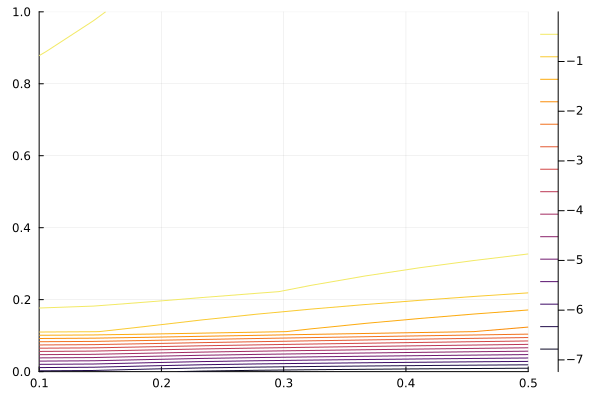

In [320]:
x = range(0.1, 0.5, length=10)
y = range(0., 1, length=10)
z = @. likeli_inst(x', y)
contour(x, y, z)

Finding the likelihood of the data given a certain distribution

In [430]:
likelihood([1.2,.5,41,1],data_hist,state_space,ν,init_prob)

0.9821911136901169

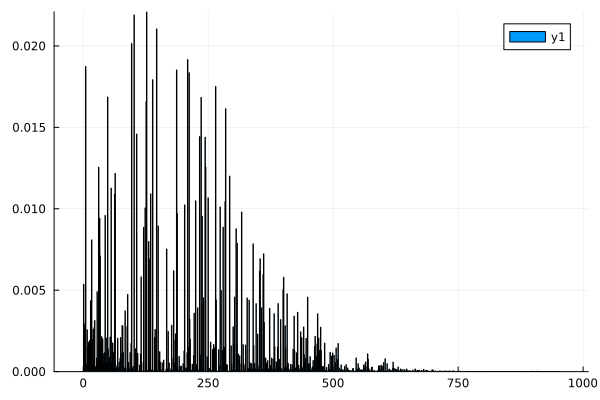

In [159]:
bar(state_distribution(4.0,reaction_rates,state_space,ν,init_prob))

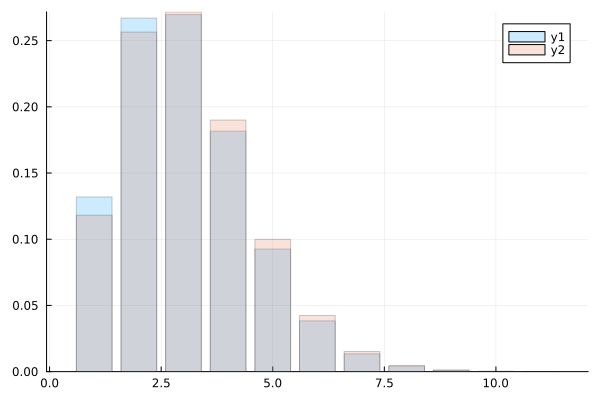

In [173]:
bar(count_distribution(4.,[1.2,.5,5.,.5,5.,.5,1.]/2,state_space,ν,init_prob)[3],alpha = 0.2)
bar!(count_distribution(4.,[1.4,.5,5.,.5,5.,.5,1.]/2,state_space,ν,init_prob)[3],alpha = 0.2)
# bar!(data_hist[2,3])

In [359]:
optim_result,reaction_rates

([0.23817132020912843, 0.15273715567314586, 2.2848590803522026, 0.18837314332679664, 2.4448196157087456, 0.43971088035412004, 0.5121486438533785], [0.6, 0.25, 2.5, 0.25, 2.5, 0.25, 0.5])

In [357]:
(optim_result- reaction_rates)./reaction_rates

7-element Vector{Float64}:
 -0.6030477996514526
 -0.38905137730741657
 -0.08605636785911894
 -0.24650742669281345
 -0.02207215371650175
  0.7588435214164801
  0.024297287706757098

**Finding the optimal reaction kinetics**

In [431]:
lower = [0.1,0.1,0.1,0.1]
upper = [5.,5.,100.,10.]
result = optimize((x->-likelihood(x,data_hist,state_space,ν,init_prob)), 
                            lower,upper,reaction_rates, 
                            Fminbox(BFGS()),
                            Optim.Options(show_trace=true,show_every=10))

Fminbox
-------
Initial mu = 4.89885e-5

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 4.89885e-5

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0    -1.000583e+00     1.129126e-01
 * time: 0.0005450248718261719
    10    -1.004301e+00     5.197851e-09
 * time: 9.48540997505188

Exiting inner optimizer with x = [1.1278920692340408, 0.48796693005107555, 40.03860624896828, 0.9986339620450401]
Current distance to box: 0.387967
Decreasing barrier term μ.

Fminbox iteration 2
-------------------
Calling inner optimizer with mu = 4.89885e-8

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0    -1.003723e+00     1.148325e-04
 * time: 7.295608520507812e-5

Exiting inner optimizer with x = [1.1275134610951187, 0.48779492869548086, 40.0286001603491, 0.9983812955673228]
Current distance to box: 0.387795
Decreasing barrier term μ.

Fminbox iteration 3
-------------------
Calling inne

 * Status: success

 * Candidate solution
    Final objective value:     -1.003723e+00

 * Found with
    Algorithm:     Fminbox with BFGS

 * Convergence measures
    |x - x'|               = 1.03e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.58e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 3.91e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   20  (vs limit Inf)
    Iterations:    3
    f(x) calls:    53
    ∇f(x) calls:   53


In [353]:
optim_result = [0.23817132020912843, 0.15273715567314586, 2.2848590803522026, 0.18837314332679664, 2.4448196157087456, 0.43971088035412004, 0.5121486438533785]
[0.6,0.25,2.5,.25,2.5,0.43,.51]

7-element Vector{Float64}:
 0.6
 0.25
 2.5
 0.25
 2.5
 0.43
 0.51

In [302]:
result = optimize((x->-likelihood(x,data_hist,state_space,ν,init_prob)), 
                            reaction_rates/2,
                            Optim.Options(
                             iterations = 1000))

LoadError: InterruptException:

In [299]:
Optim.minimizer(result)

7-element Vector{Float64}:
 0.23025837006940855
 0.15612358444589616
 1.3565129873917812
 0.16442727117549882
 1.3306434022016647
 0.13172056638729324
 0.296161036300855

In [282]:
reaction_rates

7-element Vector{Float64}:
 0.6
 0.25
 2.5
 0.25
 2.5
 0.25
 0.5

In [728]:
reaction_rates_hat = Optim.minimizer(result)
(reaction_rates_hat-reaction_rates)./reaction_rates

4-element Vector{Float64}:
 -0.06946456203309878
 -0.05724404699978092
 -0.05316721111587981
 -0.06842493974573016

## Designing the Dataset

In [82]:
function create_dataset(data::AbstractArray{Int64,3},state::AbstractArray{Int64,2})
    new_data = zeros(size(data,1),size(data,3),length(unique!(sort!(state[:,4]))))

    for i in range(1,size(data,1))
        for j in range(1,size(data,3))
            for (k,v) in countmap(data[i,:,j])
                new_data[i,j,k+1] = v
            end
            new_data[i,j,:] = new_data[i,j,:] |> (y-> y/sum(y))
        end
    end
    return new_data
end

create_dataset (generic function with 1 method)

In [83]:
data = species[:,200:200:1200,:]
data = permutedims(data,(2,1,3))
data_hist = create_dataset(data,state_space);

## Plots

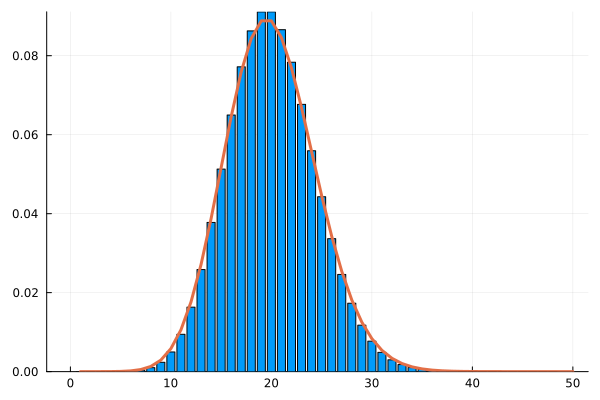

In [166]:
cd_array = count_distribution(3.,parms,state_space,nu,init_prob);
bar(cd_array[3],legend = false)
plot!(1:1:50,pdf(Poisson(20),1:1:50),linewidth=3)

In [128]:
m = zeros(51,3)
for (i,t) in enumerate(0:.1:5)
    m[i,:] = state_distribution(t,parms,state_space,nu,init_prob)'*state_space
end

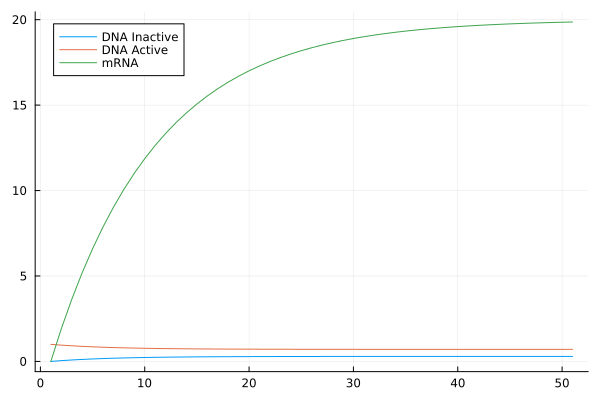

In [119]:
plot(m,label=["DNA Inactive" "DNA Active" "mRNA"])

In [246]:
using Graphs

Precompiling Graphs
  ✓ Graphs
  1 dependency successfully precompiled in 10 seconds. 21 already precompiled.
[ Info: Precompiling Graphs [86223c79-3864-5bf0-83f7-82e725a168b6]
┌ Warning: Module StaticArrays with build ID fafbfcfd-72ca-d15e-0008-49d2312d4b29 is missing from the cache.
│ This may mean StaticArrays [90137ffa-7385-5640-81b9-e52037218182] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
[ Info: Skipping precompilation since __precompile__(false). Importing Graphs [86223c79-3864-5bf0-83f7-82e725a168b6].
[ Info: Precompiling ArnoldiMethod [ec485272-7323-5ecc-a04f-4719b315124d]
┌ Warning: Module StaticArrays with build ID fafbfcfd-72ca-d15e-0008-49d2312d4b29 is missing from the cache.
│ This may mean StaticArrays [90137ffa-7385-5640-81b9-e52037218182] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
[ Info: Skipping precompilation since __precompile__(false). Importing ArnoldiMethod 

In [258]:
Q_Matrix = Matrix{Int64}(Q.!=0)

134×134 Matrix{Int64}:
 1  1  0  0  1  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  0  0  0  1  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  1  1  0  0  0  0  1  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  1  0  1  0  0  0  0  1  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  1  0  1  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  1  0  0  0  1  0  0  1  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  1  0  1  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1  0  1  0  1  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0  1  0  1  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  1  0  1  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0  1  0  1  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1  0  0  0  1  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  1   

In [249]:
[0 1 0 0 0; 0 0 1 0 0; 1 0 0 1 0; 0 0 0 0 1; 0 0 0 1 0]

5×5 Matrix{Int64}:
 0  1  0  0  0
 0  0  1  0  0
 1  0  0  1  0
 0  0  0  0  1
 0  0  0  1  0

In [259]:
g = SimpleDiGraph(Q_Matrix)

{134, 463} directed simple Int64 graph

In [260]:
strongly_connected_components(g)

1-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 6, 10, 8, 12, 14, 15  …  28, 27, 20, 18, 19, 13, 11, 9, 7, 5]

In [261]:
is_strongly_connected(g)

true